In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from astropy.time import Time
from astropy.coordinates import get_moon, GCRS
import astropy.units as u

The purpose of this notebook is to search through the COSMOS field objects to identify candidates that are likely supernovae. This is done by selecting every candidate that has at least 10 detections over at least 1 month, with a change of at least 1.4 mag, and that doesn't increase in brightness more than once (numbers adjustable in next cell)

In [2]:
tspanr, tspang = 15, 15
numdetr, numdetg = 10, 10
minmagr, minmagg = 1.4, 1.4

In [3]:
dbuser = 'kennedyt' # input("DB User: ")
dbpasswd = 'loq81a5ocd6m' # getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

In [4]:
query = ( 'SELECT o.candidate_id, o.id, e.mjd, o.mag, e.filter, o.magerr, o.ra, o.dec FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND o.rb>0.6 '
         'ORDER BY o.candidate_id '
         'LIMIT 10000000')
cursor.execute( query )

SNquery = np.array(cursor.fetchall()).transpose()

#### Red filter:

In [5]:
# Mask to make sure we stay in the r band detections
rmsk = np.where(SNquery[4] == "r")[0]

In [6]:
# Separating out various query results and applying the r mask 
candsr, objs, magsr, magerrsr = SNquery[0][rmsk], SNquery[1].astype(float)[rmsk], SNquery[3][rmsk], SNquery[5][rmsk]
# Create an array of the dates rounded to the nearest MJD
odatesr = np.round(SNquery[2].astype(float))[rmsk]
# Create an array of unique candidates
ucandsr = np.unique(candsr)
# create an array of unique night (rounded to nearest MJD)
datesr = np.unique(odatesr)

In [7]:
# The most computationally intensive cell in the notebook (along with its g band counterpart), should take less than 2 minutes

# Create for each unique candidate an array of the dates it was observed on and store those arrays in a larger array (ucanddatesr)
ucanddatesr = np.array([odatesr[np.where(candsr==i)[0]] for i in ucandsr])
# Create for each unique candidate an array of measured magnitudes and store those arrays in a larger array (ucandmagsr)
ucandmagsr = np.array([magsr[np.where(candsr==i)[0]] for i in ucandsr])
# Create for each unique candidate an array of measured magnitude error bars and store those arrays in a larger array (ucandmagerrsr)
ucandmagerrsr = np.array([magerrsr[np.where(candsr==i)[0]] for i in ucandsr])

In [8]:
# Convert those arrays (previously strings) to floats
ucandmagsr = np.array([i.astype(float) for i in ucandmagsr])
ucandmagerrsr = np.array([i.astype(float) for i in ucandmagerrsr])
ucanddatesr = np.array([i.astype(float) for i in ucanddatesr])

In [9]:
# Calculate how many days passed between the first and last detection 
ucandranger = np.array([np.max(i) - np.min(i) for i in ucanddatesr])
# Calculate how many total times the candidates was detected
ucandnumr = np.array([len(i) for i in ucanddatesr])

In [10]:
# Make timespan and number of detection cuts
cut1r = np.where(ucandranger > tspanr)[0] # eliminate candidates whose detections dont span at least a month
cut2r = np.where(ucandnumr >= numdetr)[0] # eliminate candidates with fewer than 20 detections
cut3r = np.array([i for i in cut1r if i in cut2r]).astype(np.int64) # merge the masks

In [11]:
# Apply those cuts
cutcandsr = ucandsr[cut3r]
cutdatesr = ucanddatesr[cut3r]
cutmagsr = ucandmagsr[cut3r]
cutmagerrsr = ucandmagerrsr[cut3r]

# Create another cut for the minimum amplitude in mag
cutmagranger = np.array([np.max(i) - np.min(i) for i in cutmagsr])
cut4r = np.where(cutmagranger > minmagr)[0]

# And apply that cut as well
cutcandsr = ucandsr[cut3r][cut4r]
cutdatesr = ucanddatesr[cut3r][cut4r]
cutmagsr = ucandmagsr[cut3r][cut4r]
cutmagerrsr = ucandmagerrsr[cut3r][cut4r]

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [12]:
# Create new arrays with the same dimensions as the cutdatesr, cutmagsr, and cutmagerrs arrays (those share dimensions)
import copy
cutdatesr2 = copy.deepcopy(cutdatesr)
nightr = copy.deepcopy(cutdatesr)
nightrmag = copy.deepcopy(cutdatesr)
nightrmagerr = copy.deepcopy(cutdatesr)

for i in range(len(cutdatesr2)):
    # make an array of every night the candidate in question (candidate "i") was detected
    unightr = np.unique(cutdatesr2[i])
    for j in range(len(unightr)):
        # For each of those nights, make a mask that selects every observation that night
        msk = np.where(cutdatesr2[i] == unightr[j])[0]
        # Populate the arrays we created earlier in the cell with appropriate values for the night of the observation,
        # the average magnitude measured that night, and the error (propogated from individual errors) in that average measurement
        # NOTE: there will be meaningless numbers at the end of each (nightr/nightrmag/nightrmagerr)[i] array, left over from
        # when we created them by copying another array. It isn't elegant but it is accounted for
        nightr[i][j] = unightr[j]
        nightrmag[i][j] = np.mean(cutmagsr[i][msk])
        nightrmagerr[i][j] = np.sqrt(np.sum(cutmagerrsr[i][msk]**2))

In [13]:
# Create an array of dataframes. Each dataframe represents one candidate, and each contains "Night", "Mag", and "Magerr" columns, 
# with each row representing one night
dfr = [pd.DataFrame(np.array(
    [nightr[i][:len(np.unique(nightr[i]))], 
     nightrmag[i][:len(np.unique(nightr[i]))], 
     nightrmagerr[i][:len(np.unique(nightr[i]))]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range(len(cutcandsr))]

In [14]:
# This cell creates a mask to eliminate variable stars from the search:
varstarmskr = np.ones(len(dfr), dtype=bool)
for i in range(len(dfr)):
    num = 0
    h=0
    # First, make sure that the dataframes in the dfr array are each in chronological order
    dfr[i] = dfr[i].sort_values(by="Night")
    for j in range(len(dfr[i]["Mag"]) - 1):
        h +=1
        if num == 0:
            # On the rise, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfr[i]["Mag"][j]+dfr[i]["Magerr"][j] > dfr[i]["Mag"][j+1]-dfr[i]["Magerr"][j+1]:
                pass
            else:
                # Once that condition isn't met, 'num' changes, sending us to the descending loop
                num+=1
        if num == 1:
            # On the decline, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfr[i]["Mag"][j]-dfr[i]["Magerr"][j] < dfr[i]["Mag"][j+1]+dfr[i]["Magerr"][j+1]:
                pass
            else:
                # If this fails, it means that we went up, down, and up again--not a SN, so
                num+=1
        if num == 2 and h<10:
            # We make a note of that in the 'varstarmskr' mask
            varstarmskr[i] = False

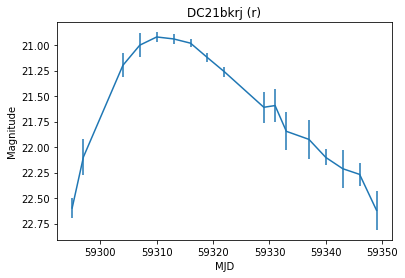

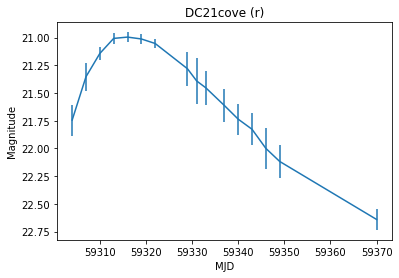

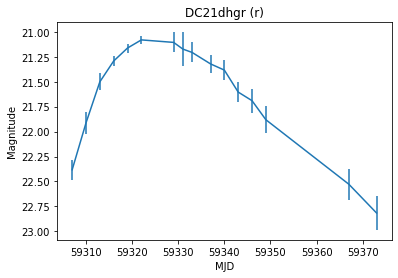

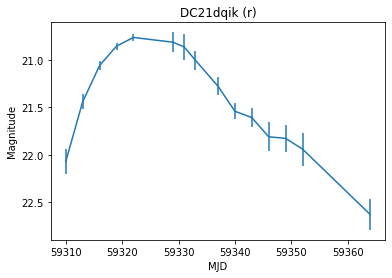

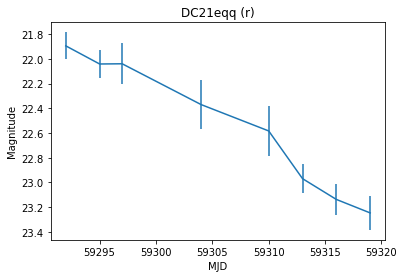

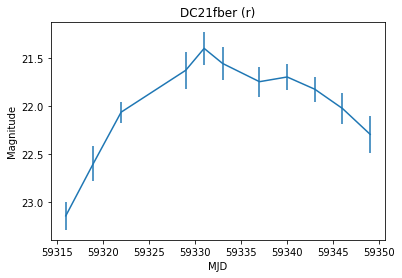

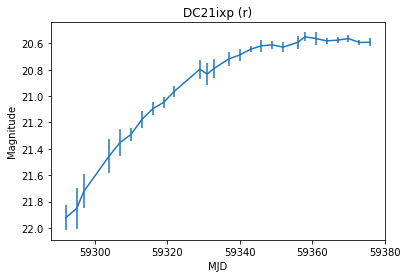

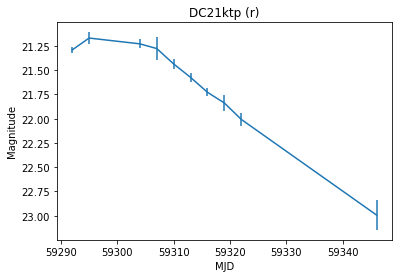

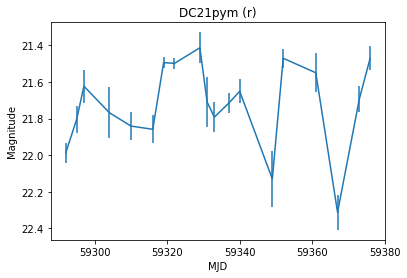

In [15]:
# Plotting only those that passed through the r-band filter
for f in np.array(range(len(cutdatesr)))[varstarmskr]:
    g = len(np.unique(cutdatesr[f]))
    plt.errorbar(nightr[f][:g],nightrmag[f][:g], yerr=nightrmagerr[f][:g])
    plt.title(cutcandsr[f] + " (r)")
    plt.ylabel("Magnitude")
    plt.xlabel("MJD")
    plt.gca().invert_yaxis()
    plt.show()

#### Green filter

In [16]:
### Everything in this section is the same as above besides some altered variable names
gmsk = np.where(SNquery[4] == "g")[0]

In [17]:
candsg, objs, magsg, magerrsg = SNquery[0][gmsk], SNquery[1].astype(float)[gmsk], SNquery[3][gmsk], SNquery[5][gmsk]
odatesg = np.round(SNquery[2].astype(float))[gmsk]
ucandsg = np.unique(candsg)
datesg = np.unique(odatesg)


In [18]:
%%time
ucanddatesg = np.array([odatesg[np.where(candsg==i)[0]] for i in ucandsg])

CPU times: user 16.7 s, sys: 36.1 ms, total: 16.7 s
Wall time: 16.5 s


In [19]:
%%time
ucandmagsg = np.array([magsg[np.where(candsg==i)[0]] for i in ucandsg])
ucandmagerrsg = np.array([magerrsg[np.where(candsg==i)[0]] for i in ucandsg])

CPU times: user 33.1 s, sys: 44.1 ms, total: 33.2 s
Wall time: 33.2 s


In [20]:
ucandmagsg = np.array([i.astype(float) for i in ucandmagsg])
ucandmagerrsg = np.array([i.astype(float) for i in ucandmagerrsg])
ucanddatesg = np.array([i.astype(float) for i in ucanddatesg])

In [21]:
ucandrangeg = np.array([np.max(i) - np.min(i) for i in ucanddatesg])
ucandnumg = np.array([len(i) for i in ucanddatesg])

In [22]:
cut1g = np.where(ucandrangeg > tspang)[0] # eliminate candidates whose detections dont span at least a month
cut2g = np.where(ucandnumg > numdetg)[0] # eliminate candidates with fewer than 20 detections
cut3g = np.array([i for i in cut1g if i in cut2g]).astype(np.int64) # merge the masks

In [23]:
cutcandsg = ucandsg[cut3g]
cutdatesg = ucanddatesg[cut3g]
cutmagsg = ucandmagsg[cut3g]
cutmagerrsg = ucandmagerrsg[cut3g]
cutmagrangeg = np.array([np.max(i) - np.min(i) for i in cutmagsg])
cut4g = np.where(cutmagrangeg > minmagg)[0]


cutcandsg = ucandsg[cut3g][cut4g]
cutdatesg = ucanddatesg[cut3g][cut4g]
cutmagsg = ucandmagsg[cut3g][cut4g]
cutmagerrsg = ucandmagerrsg[cut3g][cut4g]

In [24]:
import copy
cutdatesg2 = copy.deepcopy(cutdatesg)
nightg = copy.deepcopy(cutdatesg)
nightgmag = copy.deepcopy(cutdatesg)
nightgmagerr = copy.deepcopy(cutdatesg)

for i in range(len(cutdatesg2)):
    unightg = np.unique(cutdatesg2[i])
    for j in range(len(unightg)):
        msk = np.where(cutdatesg2[i] == unightg[j])[0]
        nightg[i][j] = unightg[j]
        nightgmag[i][j] = np.mean(cutmagsg[i][msk])
        nightgmagerr[i][j] = np.sqrt(np.sum(cutmagerrsg[i][msk]**2))

In [25]:
dfg = [pd.DataFrame(np.array(
    [nightg[i][:len(np.unique(nightg[i]))], 
     nightgmag[i][:len(np.unique(nightg[i]))], 
     nightgmagerr[i][:len(np.unique(nightg[i]))]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range(len(cutcandsg))]

In [26]:
varstarmskg = np.ones(len(dfg), dtype=bool)
for i in range(len(dfg)):
    num = 0
    h = 0
    dfg[i] = dfg[i].sort_values(by="Night")
    for j in range(len(dfg[i]["Mag"]) - 1):
        h+=1
        if num == 0:
            if dfg[i]["Mag"][j]+dfg[i]["Magerr"][j] > dfg[i]["Mag"][j+1]-dfg[i]["Magerr"][j+1]:
                pass
            else:
                num+=1
        if num == 1:
            if dfg[i]["Mag"][j]-dfg[i]["Magerr"][j] < dfg[i]["Mag"][j+1]+dfg[i]["Magerr"][j+1]:
                pass
            else:
                num+=1
        if num == 2 and h<10:
            varstarmskg[i] = False

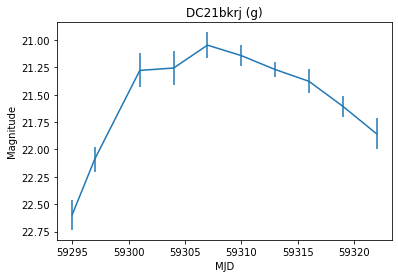

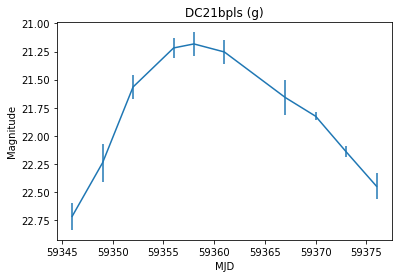

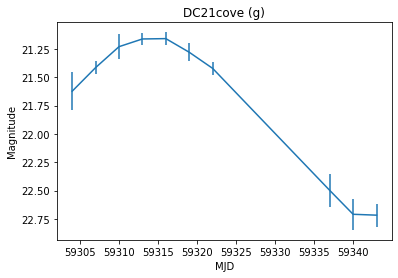

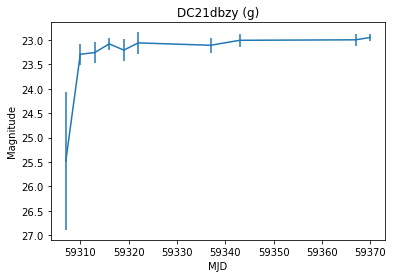

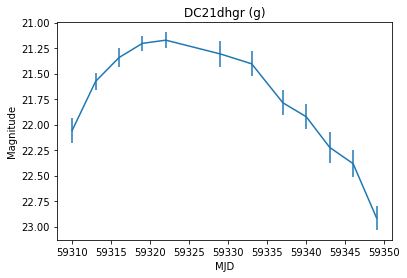

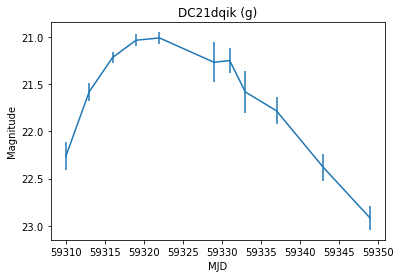

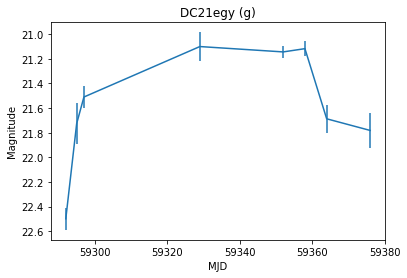

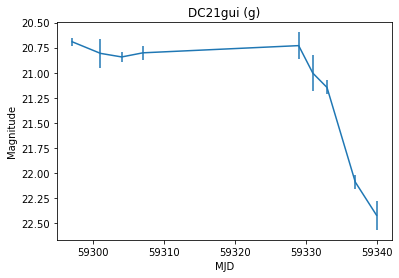

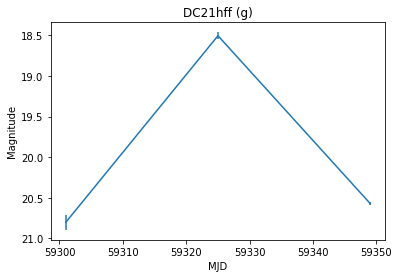

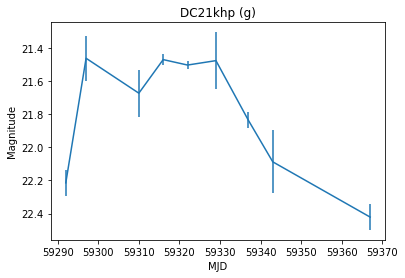

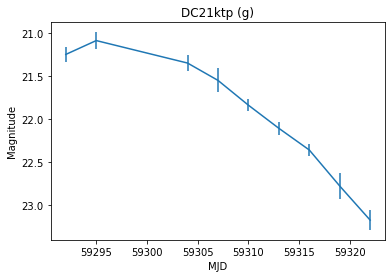

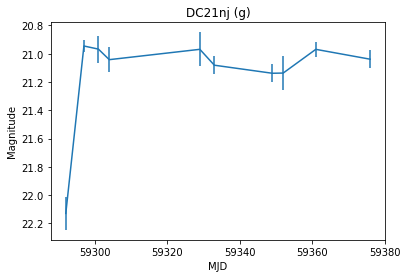

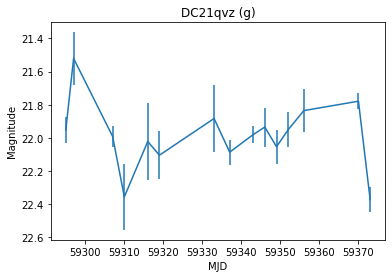

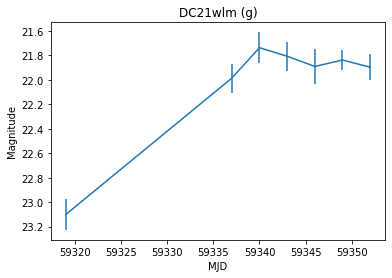

In [27]:
for f in np.array(range(len(cutdatesg)))[varstarmskg]:
    g = len(np.unique(cutdatesg[f]))
    plt.errorbar(nightg[f][:g],nightgmag[f][:g], yerr=nightgmagerr[f][:g])
    plt.title(cutcandsg[f]+" (g)")
    plt.ylabel("Magnitude")
    plt.xlabel("MJD")
    plt.gca().invert_yaxis()
    plt.show()

In [28]:
# Create lists of the candidates that passed each test
SNr = [cutcandsr[f] for f in np.array(range(len(cutdatesr)))[varstarmskr]]
SNg = [cutcandsg[f] for f in np.array(range(len(cutdatesg)))[varstarmskg]]

# Select the ones they share
SNrg = [i for i in SNr if i in SNg]

In [29]:
# And look at them!
SNrg

['DC21bkrj', 'DC21cove', 'DC21dhgr', 'DC21dqik', 'DC21ktp']

#### A closer look at these SN

In [30]:
# Taking a look at their coordinates:
for i in SNrg:
    query = ('SELECT c.id, c.ra, c.dec FROM candidates c '
            'WHERE c.id=%s ')
    cursor.execute( query, (i, ) )
    print(cursor.fetchall())

[['DC21bkrj', 150.043978544436, 3.47660190275974]]
[['DC21cove', 150.205260592532, 3.74323011868333]]
[['DC21dhgr', 148.96669780135, 1.65455109542668]]
[['DC21dqik', 151.689426712647, 2.00556682067166]]
[['DC21ktp', 149.385740426683, 2.8139035077278]]


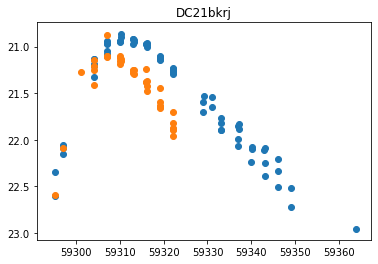

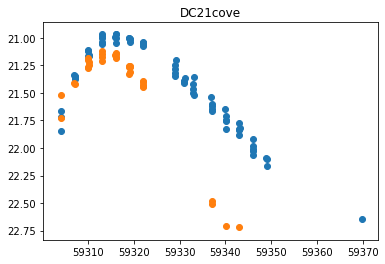

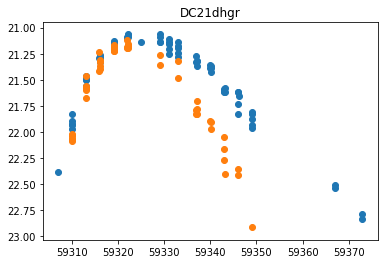

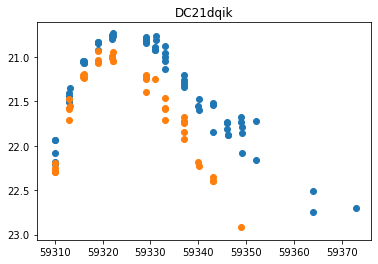

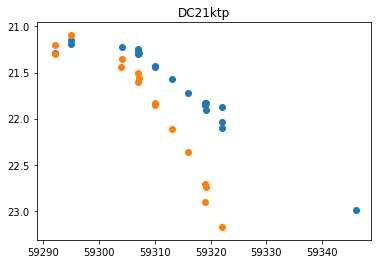

In [40]:
for i in SNrg:
    query = ('SELECT c.id, e.mjd, o.mag, e.filter FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
            'WHERE c.id=%s ')
    cursor.execute( query, (i, ) )
    array = np.array(cursor.fetchall()).transpose()
    rmsk = np.where(array[3]=='r')[0]
    gmsk = np.where(array[3]=='g')[0]
    plt.scatter((array[1][rmsk]).astype(float), (array[2][rmsk]).astype(float))
    plt.scatter((array[1][gmsk]).astype(float), (array[2][gmsk]).astype(float))
    plt.title(array[0][0])
    plt.gca().invert_yaxis()
    plt.show()

In [31]:
# DC21cove is new to TNS
# DC21dhgr is new to TNS
# DC21dqik is AKA AT2021nfp https://sne.space/sne/AT2021nfp/
# Expect to find 24 SNe Ia.

In [41]:
### This cell pulls out the reference, science, and subtraction images for eack of the SNe the filter detected, for every good detection

for i in SNrg:
    query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
              'INNER JOIN objects o ON c.object_id=o.id '
              'INNER JOIN candidates cand ON o.candidate_id=cand.id '
              'INNER JOIN subtractions s ON o.subtraction_id=s.id '
              'INNER JOIN exposures e ON s.exposure_id=e.id '
              'WHERE cand.id=%s '
              'AND o.rb>0.6'
              'ORDER BY e.mjd ')
    cursor.execute( query, ( i, ) )
    for row in cursor:
        label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
        newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
        refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
        subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
        box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
        display( box )
    print("")
    print("")    
    print("")    
    print("")    